[![preview notebook](https://img.shields.io/static/v1?label=render%20on&logo=github&color=87ce3e&message=GitHub)](https://github.com/open-atmos/PySDM/blob/main/examples/PySDM_examples/Gedzelman_and_Arnold_1994/fig_2.ipynb)
[![launch on mybinder.org](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/open-atmos/PySDM.git/main?urlpath=lab/tree/examples/PySDM_examples/Gedzelman_and_Arnold_1994/fig_2.ipynb)
[![launch on Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-atmos/PySDM/blob/main/examples/PySDM_examples/Gedzelman_and_Arnold_1994/fig_2.ipynb)

#### based on Fig. 2 from Gedzelman and Arnold 1994 (JGR)  "_Modeling the isotopic composition of precipitation_"
https://doi.org/10.1029/93JD03518

**notes**:
- "b" defined in eq. (18) lacks multiplication by $\rho_\text{s}$ - units do not match, plot matches the one generated with $\rho_\text{s}$ included - seems a typo in eq. (18)

**extentions (see notebook cells below first figure):**
- multiple isotopes (D, $^{18}$O, $^{17}$O)
- modern parameterisations: Horita & Wesolowski '94 for D & $^{18}$O equil. fractionation, Barkan & Luz '05 for $^{17}$O, Hellmann & Harvey '20 for diffusivities
- environment ratio plot axis
- temperature dependence

In [1]:
import os, sys
os.environ['NUMBA_THREADING_LAYER'] = 'workqueue'  # PySDM & PyMPDATA don't work with TBB; OpenMP has extra dependencies on macOS
if 'google.colab' in sys.modules:
    !pip --quiet install open-atmos-jupyter-utils
    from open_atmos_jupyter_utils import pip_install_on_colab
    pip_install_on_colab('PySDM-examples', 'PySDM')

In [2]:
# pylint: disable=redefined-outer-name

from types import SimpleNamespace
from dataclasses import dataclass, replace
import numpy as np
from matplotlib import pyplot
from matplotlib.lines import Line2D
from open_atmos_jupyter_utils import show_plot

from PySDM import Formulae, Builder
from PySDM.environments import Box
from PySDM.backends import CPU
from PySDM.dynamics import Condensation, IsotopicFractionation
from PySDM.dynamics.isotopic_fractionation import HEAVY_ISOTOPES
from PySDM.physics.constants import si, PER_MILLE, in_unit, PER_CENT

#### derivations:

- Maxwell-Mason equation (introducing $\rho_\text{s}=\frac{p_\text{vs}}{R_\text{v}T}$, approximated for $S_\text{eq}\approx 1$ and taking into account $\frac{l_\text{v}}{R_\text{v} T} \approx 20 \gg 1$):
$$
a\frac{da}{dt} 
= f \frac{
    S - S_\text{eq}
}{
    \rho_w \left(
        \frac{R_\text{v} T }{\Psi p_\text{vs}(T)} + 
        \frac{l_\text{v}}{K T} \left(\frac{l_\text{v}}{R_\text{v} T}-1\right)
    \right)
}
\approx \frac{f}{\rho_\text{w}} \frac{S - 1}{        \frac{1}{\Psi \rho_\text{s}} + 
        \frac{l^2_\text{v}}{K R_v T^2}
}
= \frac{f \Psi \rho_\text{s}}{\rho_\text{w}} \frac{S - 1}{        1 + 
        \frac{\Psi \rho_\text{s} l^2_\text{v}}{K R_v T^2}
}
$$
where $t$ is time, $a$ is drop radius, $f$ is ventilation factor, $\Psi$ is mass diffusion coefficient, $K$ thermal diffusion coefficient, $l_\text{v}$ is latent heat of condensation, $R_\text{v}$ gas constant for water vapour, $T$ temperature, $\rho_\text{w}$ density of water, $\rho_\text{s}$ saturation vapour density.

In [3]:
CONST = Formulae().constants
print(f"lv/(Rv T) at the triple point: {CONST.l_tri / (CONST.Rv * CONST.T_tri):.3g}")
CONST = None

lv/(Rv T) at the triple point: 19.8


- expressed in terms of mass $m=\frac{4}{3}\pi a^3 \rho_\text{w}$:

$$\frac{dm}{dt} / [\text{surface}]
= \frac{d\left(\frac{4}{3}\pi a^3 \rho_\text{w}\right)}{dt} \frac{1}{4 \pi a^2}
= \rho_\text{w} \frac{da}{dt}
$$

- introducing $b=\frac{l^2_\text{v} \Psi}{K R_\text{v}T^2}$ and approximating leads to eq. (16) in the paper:

$$
\frac{dm}{dt} 
\approx 4 \pi a \Psi f \rho_\text{s}\frac{S-1}{1 + b \rho_\text{s}}
$$

In [4]:
@dataclass(frozen=True, slots=True)
class IsotopeContext:
    """Physical inputs required for isotope calculations."""
    isotope: str
    temperature: float
    delta_v: float

@dataclass(frozen=True, slots=True)
class IsotopeRatios:
    """Isotopic ratios which might be calculated from IsotopeContext instance"""
    vsmow_ratio: float
    iso_ratio_v: float
    iso_ratio_liq_eq: float

@dataclass(frozen=True, slots=True)
class FractionationCoefficients:
    """Isotopic coefficients which might be calculated from IsotopeContext instance"""
    diffusivity_ratio: float
    ventilation_ratio: float
    alpha_w: float
    b: float

class CommonsFactory:
    """Compute and assemble common isotope quantities."""

    def __init__(self, formulae):
        self._formulae = formulae
        self._const = formulae.constants

    def build(self, ctx: IsotopeContext):
        """build factory"""
        ratios = self._build_ratios(ctx)
        fractionation = self._build_fractionation(ctx)

        return Commons(
            ratios=ratios,
            fractionation=fractionation,
            saturation_for_zero_dR_condition=(
                self._formulae.isotope_ratio_evolution
                .saturation_for_zero_dR_condition
            ),
        )

    def _build_ratios(self, ctx: IsotopeContext) -> IsotopeRatios:
        """Build isotope ratios from IsotopeContext"""
        vsmow_ratio = getattr(self._const, f"VSMOW_R_{ctx.isotope}")

        iso_ratio_v = self._formulae.trivia.isotopic_delta_2_ratio(
            ctx.delta_v, vsmow_ratio
        )

        alpha_w = self._alpha_w(ctx)
        return IsotopeRatios(
            vsmow_ratio=vsmow_ratio,
            iso_ratio_v=iso_ratio_v,
            iso_ratio_liq_eq=alpha_w * iso_ratio_v,
        )

    def _build_fractionation(self, ctx: IsotopeContext) -> FractionationCoefficients:
        """Build fractionation from IsotopeContext"""
        diff_fun = getattr(
            self._formulae.isotope_diffusivity_ratios,
            f"ratio_{ctx.isotope}_heavy_to_light",
        )

        diffusivity_ratio = 1.0 / diff_fun(ctx.temperature) # check!!!

        ventilation_ratio = (
            self._formulae.isotope_ventilation_ratio
            .ratio_heavy_to_light(
                ventilation_coefficient=44.0,
                diffusivity_ratio_heavy_to_light=diffusivity_ratio,
            )
        )
        
        alpha_w = self._alpha_w(ctx)
        b = self._b(ctx.temperature)

        return FractionationCoefficients(
            diffusivity_ratio=diffusivity_ratio,
            ventilation_ratio=ventilation_ratio,
            alpha_w=alpha_w,
            b=b,
        )

    def _alpha_w(self, ctx: IsotopeContext) -> float:
        """Calculate isotopic fractionation factor for specified isotope"""
        alpha_fun = getattr(
            self._formulae.isotope_equilibrium_fractionation_factors,
            f"alpha_l_{ctx.isotope}",
        )

        if ctx.isotope == "17O":
            alpha_l_18o = (
                self._formulae.isotope_equilibrium_fractionation_factors
                .alpha_l_18O(ctx.temperature)
            )
            return alpha_fun(np.nan, alpha_l_18o)

        return alpha_fun(ctx.temperature)

    def _b(self, temperature: float) -> float: # use formulae? 
        """b factor from eq 18"""
        pvs = self._formulae.saturation_vapour_pressure.pvs_water(temperature)
        lv = self._formulae.latent_heat_vapourisation.lv(temperature)

        return (
            pvs
            / temperature
            / self._const.Rv
            * (lv / self._const.Rv / temperature - 1.0)
            * lv
            * self._const.D0
            / self._const.K0
            / temperature
        )
    
    def get_formulae(self) -> Formulae:
        """retrieve protected attribute"""
        return self._formulae
    
    def get_constants(self):
        """retrieve protected attribute"""
        return self._const

@dataclass(frozen=True, slots=True)
class Commons:
    """Grouped quantities used across isotope equations."""
    ratios: IsotopeRatios
    fractionation: FractionationCoefficients
    saturation_for_zero_dR_condition: callable

In [5]:
class NoFractionationSaturation: #pylint: disable=too-few-public-methods
    """saturation lines in isotopic equilibrium
    see fig 2. in [Gedzelman & Arnold 1994]"""
    def __init__(self, cmn: Commons, *, liquid: bool = False, vapour: bool = False):
        if liquid == vapour:
            raise ValueError("Exactly one of liquid or vapour must be True")

        self._cmn = cmn
        self._liquid = liquid

    def __call__(self, iso_ratio_r) -> float:
        ratios = self._cmn.ratios
        fractionation = self._cmn.fractionation

        return self._cmn.saturation_for_zero_dR_condition(
            iso_ratio_x=iso_ratio_r if self._liquid else ratios.iso_ratio_v,
            diff_rat_light_to_heavy=(
                fractionation.ventilation_ratio * fractionation.diffusivity_ratio
            ),
            b=fractionation.b,
            alpha_w=fractionation.alpha_w,
            iso_ratio_r=iso_ratio_r,
            iso_ratio_v=ratios.iso_ratio_v,
        )

In [6]:
K2C = Formulae().trivia.K2C
C2K = Formulae().trivia.C2K

REFERENCE_TEMPERATURE = C2K(10.0) * si.K
TEMPERATURES = np.linspace(C2K(-10.0) * si.K,
    C2K(30.0) * si.K, 9)

In [7]:
@dataclass(frozen=True, slots=True)
class PaperConfig:
    """Configuration reproducing the paper setup."""
    formulae: Formulae
    isotope: str
    delta_v: float
    temperature: float
    xlim: tuple[float, float]
    rh_unit: float

paper_config = PaperConfig(
    formulae=Formulae(
        isotope_equilibrium_fractionation_factors="MerlivatAndNief1967",
        isotope_kinetic_fractionation_factors="JouzelAndMerlivat1984",
        isotope_relaxation_timescale="ZabaEtAl",
        isotope_diffusivity_ratios="Stewart1975",
        isotope_ratio_evolution="GedzelmanAndArnold1994",
        isotope_ventilation_ratio="Neglect",  # droplet-size dependent, ignored here
        drop_growth="Mason1971",
    ),
    isotope="2H",
    delta_v=-200 * PER_MILLE,
    temperature=300,
    xlim=(0.8, 1.0),
    rh_unit=PER_CENT,
)

In [8]:
class Settings:
    """Setting for one-step simulation"""
    @staticmethod
    def make_particulator(
        *,
        ff,
        molecular_isotopic_ratio,
        initial_R_vap,
        attributes=None,
        n_sd=1,
        dv: float = np.nan,
        dt: float = -1 * si.s,
        relative_humidity: float = 1,
        T: float = 1,
    ): # pylint: disable=too-many-arguments
        """needed setup for simulation"""
        const = ff.constants
        attributes["moles_2H"] = ff.trivia.moles_heavy_atom(
            mass_total=attributes["signed water mass"],
            mass_other_heavy_isotopes=0,
            molar_mass_light_molecule=const.M_1H2_16O,
            molar_mass_heavy_molecule=const.M_2H_1H_16O,
            molecular_isotopic_ratio=molecular_isotopic_ratio,
            atoms_per_heavy_molecule=1,
        )
        builder = Builder(
            n_sd=n_sd,
            backend=CPU(
                formulae=ff,
            ),
            environment=Box(dv=dv, dt=dt),
        )
        builder.add_dynamic(Condensation())
        builder.add_dynamic(IsotopicFractionation(isotopes=("2H",)))

        builder.particulator.environment["RH"] = relative_humidity
        builder.particulator.environment["T"] = T
        rho_d = const.p_STP / const.Rd / T
        builder.particulator.environment["dry_air_density"] = rho_d

        initial_conc_vap = (
            ff.saturation_vapour_pressure.pvs_water(T) * relative_humidity / const.R_str / T
        )

        molality_2H_in_dry_air = (
            ff.trivia.molality_in_dry_air(
                isotopic_fraction=ff.trivia.isotopic_fraction_assuming_single_heavy_isotope(isotopic_ratio=initial_R_vap),
                density_dry_air=rho_d,
                total_vap_concentration=initial_conc_vap,
            )
        )

        for isotope in HEAVY_ISOTOPES:
            if isotope == "2H":
                builder.particulator.environment[f"molality {isotope} in dry air"] = (
                    molality_2H_in_dry_air
                )
            else:
                builder.particulator.environment[f"molality {isotope} in dry air"] = 0
        builder.request_attribute("delta_2H")
        return builder.build(attributes=attributes, products=())

    @staticmethod
    def do_one_step(*, ff, particulator, evaporated_mass_fraction):
        """perform one step of simulation"""
        initial_conc_vap = (
            ff.saturation_vapour_pressure.pvs_water(
                particulator.environment["T"][0]
            )
            * particulator.environment["RH"][0]
            / ff.constants.R_str
            / particulator.environment["T"][0]
        )
        isotopic_fraction = (
            ff.trivia.isotopic_fraction(
                molality_in_dry_air=particulator.environment["molality 2H in dry air"][0],
                density_dry_air=particulator.environment["dry_air_density"][0],
                total_vap_concentration=initial_conc_vap,
            )
        )
        initial_R_liq = (
            particulator.attributes["moles_2H"][0]
            / particulator.attributes["moles_1H"][0]
        )

        dm = -evaporated_mass_fraction * (
            particulator.attributes["signed water mass"][0]
            * particulator.attributes["multiplicity"][0]
        )
        
        particulator.attributes["diffusional growth mass change"].data[:] = (
            dm / particulator.attributes["multiplicity"][0]
        )
        assert np.all(
            particulator.attributes["diffusional growth mass change"].data < 0
        )
        particulator.dynamics["IsotopicFractionation"]()
        new_isotopic_fraction = (
            ff.trivia.isotopic_fraction(
                molality_in_dry_air=particulator.environment[
                    "molality 2H in dry air"
                ].data[0],
                density_dry_air=particulator.environment["dry_air_density"][0],
                total_vap_concentration=initial_conc_vap
                - dm / ff.constants.Mv / particulator.environment.mesh.dv,
            )
        )
        new_R_liq = (
            particulator.attributes["moles_2H"][0]
            / particulator.attributes["moles_1H"][0]
        )
        R_vap = ff.trivia.isotopic_ratio_assuming_single_heavy_isotope(
            isotopic_fraction=isotopic_fraction)
        new_R_vap = ff.trivia.isotopic_ratio_assuming_single_heavy_isotope(
            isotopic_fraction=new_isotopic_fraction)
        dR_vap = new_R_vap - R_vap
        dR_liq = new_R_liq - initial_R_liq
        return dR_vap / R_vap, dR_liq / initial_R_liq

In [9]:
ATTRIBUTES = {
        "dry volume": np.nan,
        "kappa times dry volume": np.nan,
        **{
            f"moles_{isotope}": 0.0 * si.mole
            for isotope in HEAVY_ISOTOPES
        },
        "multiplicity": 10*np.ones(1)
    }
commons_factory = CommonsFactory(paper_config.formulae)

COMMONS = commons_factory.build(
    IsotopeContext(
        isotope=paper_config.isotope,
        temperature=REFERENCE_TEMPERATURE,
        delta_v=paper_config.delta_v,
    )
)

In [10]:
PLOT_PARAMS = SimpleNamespace(
    grid=(12, 12),
    ylim=(0.1, 1),
    figsize=(11, 5)
)

def calculate_relative_ratio_change(
    *,
    relative_humidity,
    molecular_R_liq,
    attributes,
    commons,
    volume,
    n_sd,
    T,
    evaporated_mass_fraction,
):# pylint: disable=too-many-arguments
    """perform multiple calculations for different grid nodes
    result: matrix of relative mass change of the heavy isotope 
    in liquid and vapour phase"""
    rel_diff_vap = np.zeros((len(relative_humidity), len(molecular_R_liq)))
    rel_diff_liq = np.zeros_like(rel_diff_vap)

    for i, rh in enumerate(relative_humidity):
        for j, m_R_liq in enumerate(molecular_R_liq):
            particulator = Settings.make_particulator(
                relative_humidity=rh,
                molecular_isotopic_ratio=m_R_liq,
                ff=commons_factory.get_formulae(),
                attributes=attributes,
                initial_R_vap=commons.ratios.iso_ratio_v,
                dv=volume,
                n_sd=n_sd,
                T=T,
            )
            rel_diff_vap[i, j], rel_diff_liq[i, j] = Settings.do_one_step(
                ff=commons_factory.get_formulae(),
                particulator=particulator,
                evaporated_mass_fraction=evaporated_mass_fraction,
            )
    return rel_diff_vap, rel_diff_liq

cmn = COMMONS
const = commons_factory.get_constants()
vsmow = cmn.ratios.vsmow_ratio
x = np.linspace(cmn.ratios.iso_ratio_liq_eq / vsmow, 1.1, 200)

S_eq = {
    "liquid": NoFractionationSaturation(cmn, liquid=True)(x * vsmow),
    "vapour": NoFractionationSaturation(cmn, vapour=True)(x * vsmow)
}

In [11]:
molecular_R_liq = np.linspace(*paper_config.xlim, PLOT_PARAMS.grid[0]) * vsmow
volume = np.ones(1) * si.m**3
RH = np.linspace(*PLOT_PARAMS.ylim, PLOT_PARAMS.grid[1])
liquid_water_content = 1 * si.g / si.m**3

attributes = ATTRIBUTES.copy()
attributes["signed water mass"] = liquid_water_content * volume / attributes["multiplicity"]

rel_diff_vap, rel_diff_liq = calculate_relative_ratio_change(
    relative_humidity=RH,
    molecular_R_liq=molecular_R_liq,
    attributes=attributes,
    commons=cmn,
    volume=volume[0],
    n_sd=1,
    T=paper_config.temperature,
    evaporated_mass_fraction=0.02,
)

/Users/agnieszkazaba/PycharmProjects/PySDM/PySDM/backends/numba.py:57: UserWarning: Disabling Numba threading due to ARM64 CPU (atomics do not work yet)
  warnings.warn(


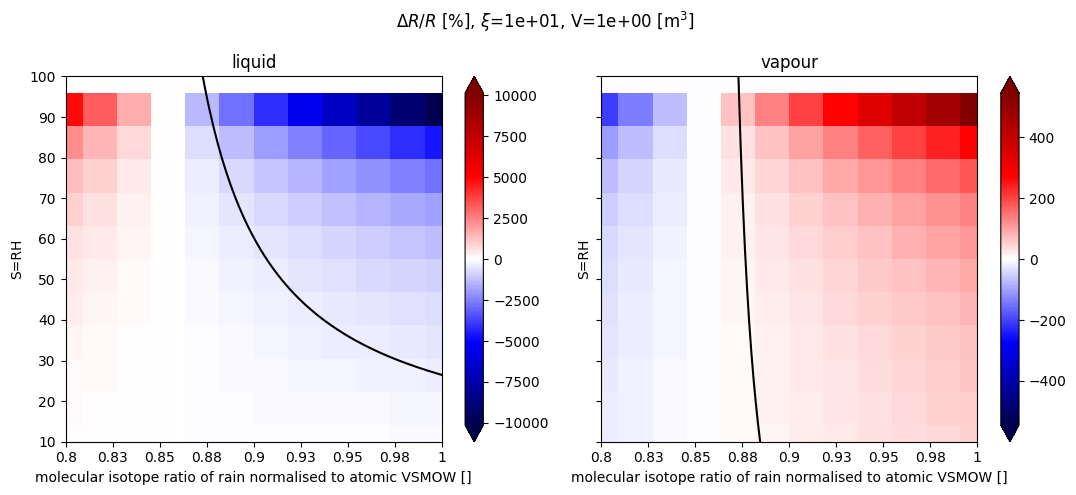

In [12]:
fig, axs = pyplot.subplots(1, 2, figsize=PLOT_PARAMS.figsize, sharex=True, sharey=True)
fig.suptitle(f"$\\Delta R/R$ [%], $\\xi$={attributes['multiplicity'][0]:.0e}, V={volume[0]:.0e} [m$^3$]")

for (ax, data, phase) in zip(axs, (rel_diff_liq, rel_diff_vap), ("liquid", "vapour")):
    data_percent = in_unit(data, PER_CENT)
    v_max = np.nanmax(np.abs(data_percent))
    pcm = ax.pcolormesh(
        molecular_R_liq / vsmow,
        in_unit(RH, paper_config.rh_unit),
        data_percent,
        cmap="seismic",
        vmax=v_max,
        vmin=-v_max,
    )
    fig.colorbar(pcm, ax=ax, extend="both")
    ax.plot(x, in_unit(S_eq[phase], paper_config.rh_unit), c="k")
    ax.set(
        title=f"{phase}",
        xlim=paper_config.xlim,
        ylim=(in_unit(PLOT_PARAMS.ylim[0], paper_config.rh_unit),
              in_unit(PLOT_PARAMS.ylim[1], paper_config.rh_unit)),
        ylabel="S=RH",
        xlabel="molecular isotope ratio of rain normalised to atomic VSMOW []",
    )

pyplot.tight_layout()
pyplot.gca().xaxis.set_major_formatter('{x:.2g}')
show_plot("R_ratios_for_liquid_and_vapour", inline_format='png')


# Second plot

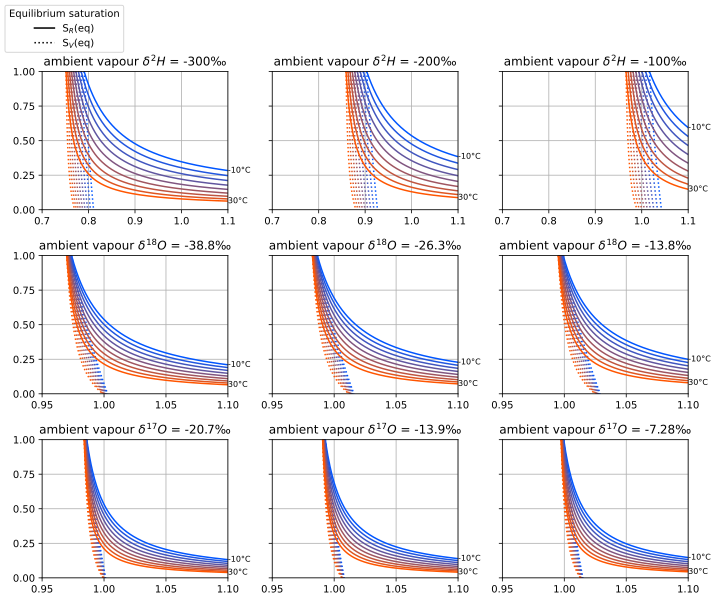

In [13]:
second_formulae = Formulae(
        isotope_equilibrium_fractionation_factors="BarkanAndLuz2005+HoritaAndWesolowski1994",
        isotope_diffusivity_ratios="HellmannAndHarvey2020",
        isotope_meteoric_water_line="BarkanAndLuz2007+Dansgaard1964",
        isotope_ratio_evolution="GedzelmanAndArnold1994",
        isotope_ventilation_ratio="Neglect",
    )
multiplot_config = replace(
    paper_config,
    formulae=second_formulae
)
commons_factory = CommonsFactory(multiplot_config.formulae)
cmn = commons_factory.build(
    IsotopeContext(
        isotope=multiplot_config.isotope,
        temperature=multiplot_config.temperature,
        delta_v=multiplot_config.delta_v,
    )
)
iso_mwl = second_formulae.isotope_meteoric_water_line
d2H = (-300, -200, -100)
deltas_2H = [x * PER_MILLE for x in d2H]
deltas_18O = [iso_mwl.d18O_of_d2H(d) for d in deltas_2H]
deltas_17O = [iso_mwl.d17O_of_d18O(d) for d in deltas_18O]

x_lim = {"2H": (0.7, 1.1), "18O": (0.95, 1.1), "17O": (0.95, 1.1)}

fig, axs = pyplot.subplots(3, 3, figsize=(10, 8), sharey=True)
Ts = TEMPERATURES
for idx_iso, iso in enumerate(("2H", "18O", "17O")):
    for j_delta, delta in enumerate((deltas_2H, deltas_18O, deltas_17O)[idx_iso]):
        ax = axs[idx_iso][j_delta]

        for t in Ts:
            cmn = commons_factory.build(IsotopeContext(iso, t, delta))
            vsmow = cmn.ratios.vsmow_ratio

            x = np.linspace(cmn.fractionation.alpha_w * cmn.ratios.iso_ratio_v / vsmow, 1.1, 200)
            y_liq = NoFractionationSaturation(cmn, liquid=True)(x * vsmow)
            y_vap = NoFractionationSaturation(cmn, vapour=True)(x * vsmow)

            c = (
                (t - Ts[0]) / (Ts[-1] - Ts[0]),
                0.333,
                1 - (t - Ts[0]) / (Ts[-1] - Ts[0])
            )
            if t in (Ts[0], Ts[-1]):
                ax.annotate(f"{K2C(t):g}°C", (x_lim[iso][1], y_liq[-1] - 0.015), fontsize=8)

            ax.plot(x, y_liq, color=c, linestyle="-")
            ax.plot(x, y_vap, color=c, linestyle=":")

        ax.set(
            title=f"ambient vapour $\\delta^{{{iso[:-1]}}}{iso[-1]}$ = {in_unit(delta, PER_MILLE):.3g}‰",
            xlim=x_lim[iso],
            ylim=(0, 1),
            yticks=np.linspace(0, 1, 5),
        )
        if j_delta != 0:
            ax.set_ylabel("")
        ax.grid(True)

legend_lines = [
    Line2D([0], [0], color="black", linestyle="-", label="S$_R$(eq)"),
    Line2D([0], [0], color="black", linestyle=":", label="S$_V$(eq)"),
]

fig.legend(legend_lines, [*[l.get_label() for l in legend_lines]], loc="upper left", title="Equilibrium saturation")
fig.tight_layout()
fig.subplots_adjust(top=0.88, bottom=0)
show_plot("plot_grid.pdf")
